<a href="https://colab.research.google.com/github/DahyoungYenuargo/Tugas_Project/blob/main/Jurnal_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=05d2127ed4281b5ff9c402c741317677f687f20f0095da6884226eef4f449d9b
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [69]:
# Import library yang diperlukan
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import *

In [70]:
# Inisialisasi SparkSession
spark = SparkSession.builder.appName('SahamPrediction').getOrCreate()

In [71]:
# Definisikan schema kolom-kolom dengan tipe data yang sesuai
schema = StructType([
    StructField("Date", StringType(), True),
    StructField("Open", DoubleType(), True),
    StructField("High", DoubleType(), True),
    StructField("Low", DoubleType(), True),
    StructField("Close", DoubleType(), True),
    StructField("Volume", DoubleType(), True),
    # Tambahkan kolom lain sesuai kebutuhan dan jenis datanya
])

In [72]:
# Memuat data dari file CSV (contoh)
df = spark.read.csv("JKSE.csv", header=True, schema=schema)
df.show()

+----------+-----------+-----------+-----------+-----------+-----------+
|      Date|       Open|       High|        Low|      Close|     Volume|
+----------+-----------+-----------+-----------+-----------+-----------+
|2019-01-02|6197.871094| 6205.89502|6164.833984|6181.174805|6181.174805|
|2019-01-03|6176.151855|6221.009766|6176.151855|6221.009766|6221.009766|
|2019-01-04|6211.096191|6274.540039|6200.854004|6274.540039|6274.540039|
|2019-01-07|6317.625977|6354.757813|6287.224121|6287.224121|6287.224121|
|2019-01-08|6292.263184|6316.240234|6251.375977|6262.847168|6262.847168|
|2019-01-09|6296.115234|6311.579102|6265.326172|6272.237793|6272.237793|
|2019-01-10|6293.958008|6328.713867|6268.507813|6328.713867|6328.713867|
|2019-01-11|6347.973145|6361.464844|6337.547852|6361.464844|6361.464844|
|2019-01-14|6351.329102|   6359.875|6302.395996|6336.116211|6336.116211|
|2019-01-15|6347.101074| 6408.78418|6333.644043| 6408.78418| 6408.78418|
|2019-01-16|6417.130859|6425.940918|6385.589844|641

In [73]:
# Menampilkan skema DataFrame
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: double (nullable = true)



In [74]:
# Menghapus baris yang memiliki nilai null di kolom-kolom tertentu
df_cleaned = df.na.drop(subset=["Open", "High", "Low", "Close", "Volume"])

In [75]:
# Memilih fitur yang akan digunakan untuk prediksi (misalnya: 'Open', 'High', 'Low', 'Volume')
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Membuat assembler untuk menggabungkan fitur-fitur menjadi satu kolom "features"
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Transformasi data menggunakan VectorAssembler
data = assembler.transform(df_cleaned)

In [76]:
# Memisahkan data menjadi set pelatihan (80%) dan set pengujian (20%)
train_data, test_data = data.randomSplit([0.8, 0.2])

In [77]:
# Inisialisasi model Decision Tree
dt = DecisionTreeRegressor(featuresCol='features', labelCol='Close')

# Melatih model Decision Tree
dt_model = dt.fit(train_data)

In [78]:
# Inisialisasi model Random Forest
rf = RandomForestRegressor(featuresCol='features', labelCol='Close')

# Melatih model Random Forest
rf_model = rf.fit(train_data)

In [79]:
# Evaluasi performa model Decision Tree pada data pengujian
dt_predictions = dt_model.transform(test_data)
dt_evaluator = RegressionEvaluator(labelCol='Close', metricName='rmse')
dt_rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (Decision Tree):", dt_rmse)

Root Mean Squared Error (Decision Tree): 52.5812587821303


In [80]:
# Evaluasi performa model Random Forest pada data pengujian
rf_predictions = rf_model.transform(test_data)
rf_evaluator = RegressionEvaluator(labelCol='Close', metricName='rmse')
rf_rmse = rf_evaluator.evaluate(rf_predictions)
print("Root Mean Squared Error (Random Forest):", rf_rmse)

Root Mean Squared Error (Random Forest): 47.47540564897907


In [81]:
from pyspark.ml.evaluation import RegressionEvaluator

# Melakukan prediksi dengan model yang telah dilatih sebelumnya (misalnya model rf_model)
predictions = rf_model.transform(test_data)

# Membuat evaluator untuk R-squared
evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="r2")

# Menghitung R-squared
r2 = evaluator.evaluate(predictions)
print("R-squared:", r2)


R-squared: 0.9948730131898919


In [82]:
from pyspark.sql.functions import col

# Evaluasi performa model Decision Tree pada data pengujian
dt_predictions = dt_model.transform(test_data)

# Menghitung deviasi antara prediksi dan harga saham aktual
dt_predictions = dt_predictions.withColumn("Deviation", (col("prediction") - col("Close")) / col("Close"))

# Menghitung akurasi relatif dalam bentuk persentase
accuracy_percentage = (1 - dt_predictions.select("Deviation").agg({"Deviation": "mean"}).collect()[0][0]) * 100
print(f"Akurasi Relatif Model Decision Tree: {accuracy_percentage:.2f}%")


Akurasi Relatif Model Decision Tree: 99.97%


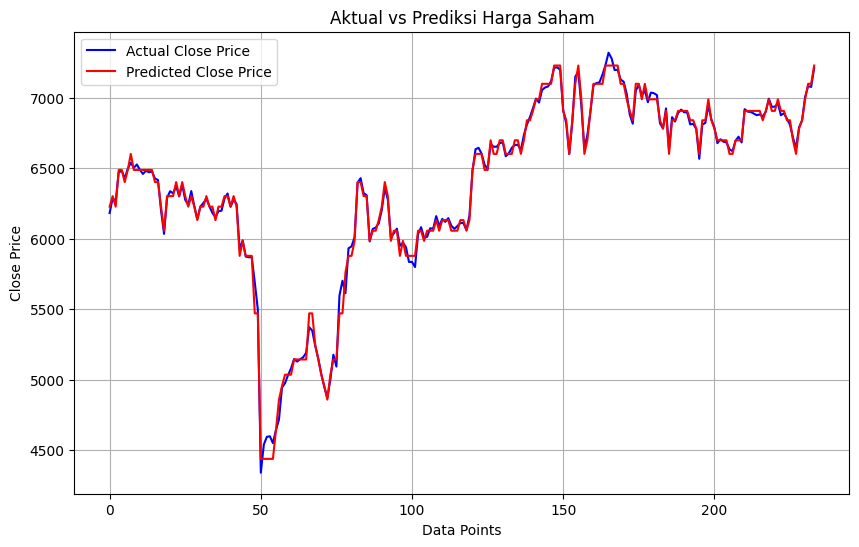

In [57]:
import matplotlib.pyplot as plt
import pandas as pd

# Konversi hasil prediksi menjadi DataFrame Pandas
dt_pred_pd = dt_predictions.select("Close", "prediction").toPandas()

# Mengurutkan berdasarkan tanggal jika diperlukan
# dt_pred_pd.sort_values(by='Date', inplace=True)

# Plot harga saham aktual dan prediksi
plt.figure(figsize=(10, 6))
plt.plot(dt_pred_pd['Close'], label='Actual Close Price', color='blue')
plt.plot(dt_pred_pd['prediction'], label='Predicted Close Price', color='red')

plt.title('Aktual vs Prediksi Harga Saham')
plt.xlabel('Data Points')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

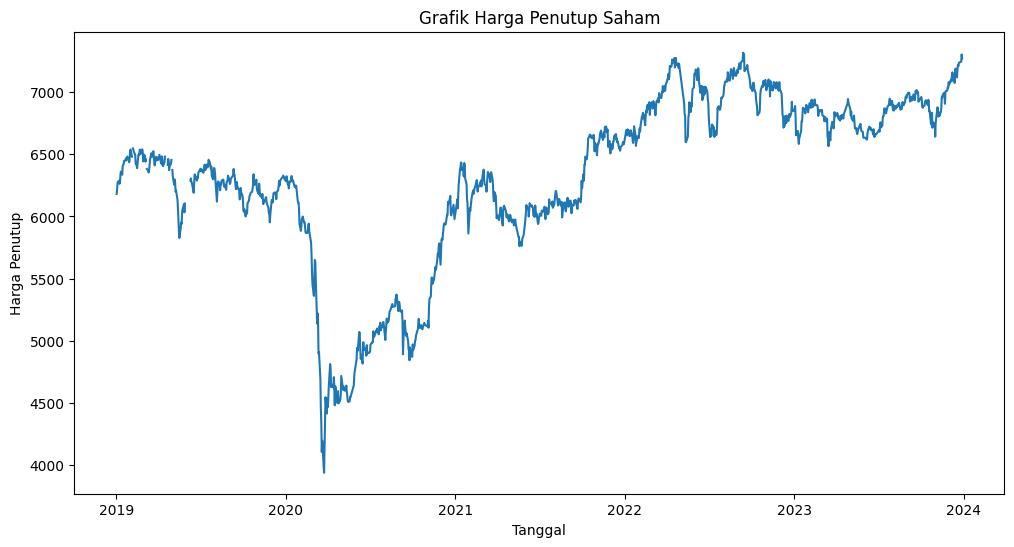

In [83]:
# Visualisasi candlestick chart menggunakan PySpark DataFrame
df = df.withColumn("Date", col("Date").cast("date"))
df_pd = df.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(df_pd['Date'], df_pd['Close'])
plt.title('Grafik Harga Penutup Saham')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutup')
plt.show()

<Figure size 1000x600 with 0 Axes>

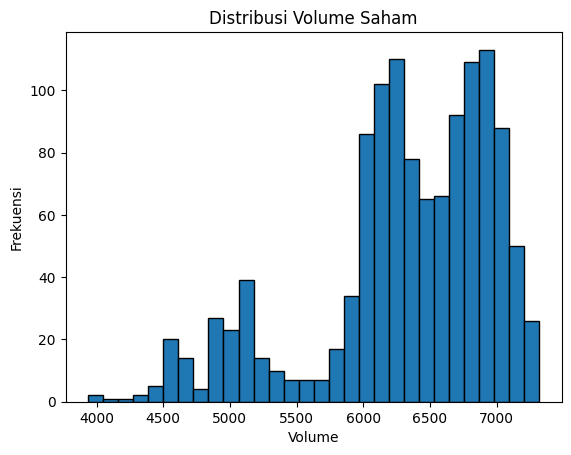

In [84]:
# Visualisasi distribusi Volume menggunakan PySpark DataFrame
plt.figure(figsize=(10, 6))
df.select('Volume').toPandas().hist(bins=30, grid=False, edgecolor='black')
plt.title('Distribusi Volume Saham')
plt.xlabel('Volume')
plt.ylabel('Frekuensi')
plt.show()

In [86]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import when

# Menambahkan kolom label
df_labeled = df_cleaned.withColumn("Label", when(df_cleaned["Close"] > df_cleaned["Open"], 1).otherwise(0))

# Membuat assembler baru dengan kolom label
assembler_with_label = VectorAssembler(inputCols=feature_columns, outputCol='features_with_label')

# Transformasi data menggunakan VectorAssembler
data_with_label = assembler_with_label.transform(df_labeled)

# Memisahkan data dengan label menjadi set pelatihan dan set pengujian
train_data_label, test_data_label = data_with_label.randomSplit([0.8, 0.2])

# Inisialisasi model Logistic Regression
lr = LogisticRegression(featuresCol='features_with_label', labelCol='Label')

# Melatih model Logistic Regression
lr_model = lr.fit(train_data_label)

# Evaluasi performa model Logistic Regression pada data pengujian
lr_predictions = lr_model.transform(test_data_label)
lr_evaluator = BinaryClassificationEvaluator(labelCol='Label', metricName='areaUnderROC')
area_under_roc = lr_evaluator.evaluate(lr_predictions)
print("Area Under ROC (Logistic Regression):", area_under_roc)


Area Under ROC (Logistic Regression): 1.0
